# Resampling

Working with imbalanced data has a lot of downsides. In this notebook we will look at the influence of resampling of the imbalanced data for active learning.

By using resampling we can remove some samples from the larger class and add some samples to the smaller class.

[See here](https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets) for more info on resampling.
We will use the [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library for this.

In [15]:
## Imports ##

# numpy
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import MISSING_LABEL

# imbalanced-learn
from imblearn.combine import SMOTETomek, SMOTEENN

# plot function
from plot_accuracy import plot_accuracy

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

In [16]:
def get_data(n_samples, n_features, n_redundant, weights, random_state, resampling=None):
    # generate classification problem
    Xc, yc = make_classification(n_samples=n_samples, n_features=n_features, n_redundant=n_redundant, weights=weights, random_state=random_state);
    # split train and test data
    Xf, Xt, yf, yt = train_test_split(Xc, yc, random_state=random_state)
    # apply resapling to the train data
    if resampling != None:
        Xf, yf = resampling().fit_resample(Xf, yf)
    return Xf, Xt, yf, yt


In [21]:
def get_balanced_accuracy(weights=None, cycles=30, n_samples=400, resampling=None, **kwargs):
    data = []
    for rand in range(100):
        Xf, Xt, yf, yt = get_data(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand, resampling=resampling)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(yf))
        qs = UncertaintySampling(random_state=rand, **kwargs)

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clf)
            y[i] = yf[i]
            clf.fit(Xf,y)
            out.append(balanced_accuracy(yt,clf.predict(Xt))) # new addition
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [24]:
data_normal = get_balanced_accuracy(weights=[0.8,0.2])
data_SMOTETomek = get_balanced_accuracy(weights=[0.8,0.2], resampling=SMOTETomek)
data_SMOTEENN = get_balanced_accuracy(weights=[0.8,0.2], resampling=SMOTEENN)

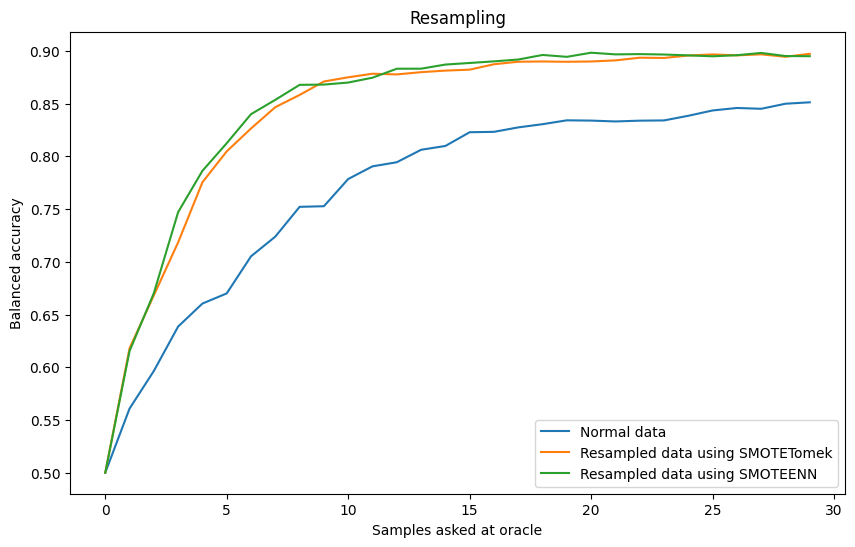

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plot_accuracy('Resampling',[[data_normal, 'Normal data'],
                            [data_SMOTETomek, 'Resampled data using SMOTETomek'],
                            [data_SMOTEENN, 'Resampled data using SMOTEENN']],
                            axs)
fig.show()